# Experiments with strategies on a random walk

Let's see if we can lock in wins and avoid losses, even if the stockmarket is modelled as a pure random walk

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

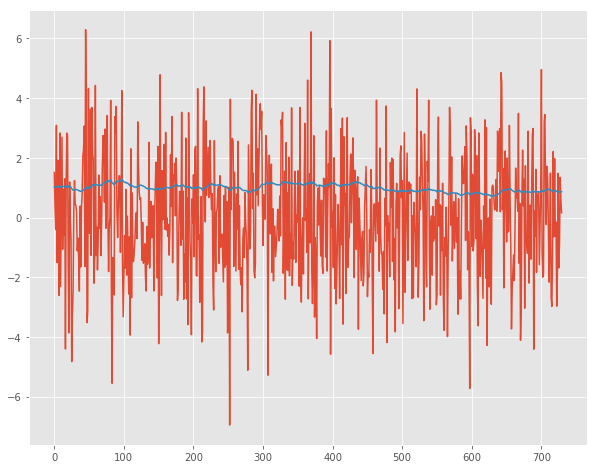

In [2]:
# Normal distribution with std 2
# TODO: check: How does this assumption fit reality?

valuation_changes = np.random.randn(730) * 2
valuations_cum = np.cumprod((valuation_changes / 100) + 1)

plt.gcf().set_size_inches(10,8)
plt.plot(valuation_changes)
plt.plot(valuations_cum);

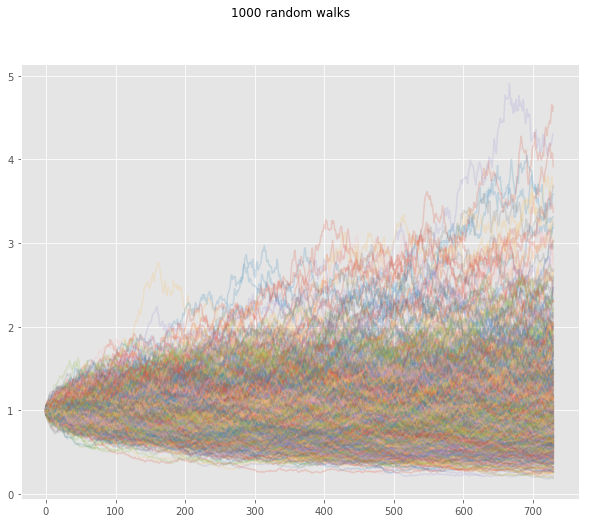

In [3]:
n = 1000
random_walks = []
f = plt.figure(figsize=(10,8))
f.suptitle('1000 random walks')

for i in range(n):
    valuation_changes = np.random.randn(730) * 2
    valuations_cum = np.cumprod((valuation_changes / 100) + 1)
    random_walks.append(valuations_cum)
    
    plt.plot(valuations_cum, alpha=0.2)
    

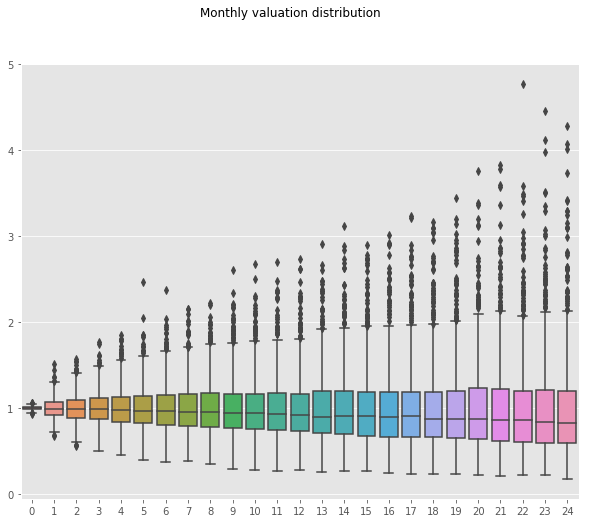

In [4]:
days = list(zip(*random_walks))
f = plt.figure(figsize=(10,8))
f.suptitle('Monthly valuation distribution')

months = []
for n in range(0,730,30):
    months.append(days[n])

sns.boxplot(data=months);

In [11]:
def random_walk():
    '''price in units of currency per unit of stock
    price change as change per one (not percent)
    '''
    dates = pd.date_range('1/1/2001', periods= 730)
    valuation_changes = pd.Series((np.random.randn(len(dates)) * 2 / 100) + 1, index=dates)
    valuations_cum = np.cumprod(valuation_changes)
    df = pd.DataFrame({'price_change' : valuation_changes, 'price' : valuations_cum})
    
    return df

In [6]:
# Holdings are holdings at the end of the day
# Prices are in units of currency / units of stock
# Holdings are in    units of stock
# Price_paid is in   unit of currency
# daily_buy is in    unit of currency

def strategy_1(df, threshold = 1.1, daily_buy=100, fraction_to_sell=1.0):    
    working_copy = df.copy().reindex(columns=['price', 'price_change', 'rentability', 
                                              'purchases', 'sales', 'holdings', 
                                              'cash_paid', 'cash', 'overall_return'])
    
    for index, day in working_copy.iterrows():
        # Set up the framework on the first day:
        if index == working_copy.iloc[0].name:
            day_0 = day
            day_0['rentability'] = np.nan
            day_0['purchases'] = daily_buy / day_0['price']
            day_0['holdings'] = day_0['purchases']
            day_0['cash_paid'] = day_0['purchases'] * day_0['price']
            day_0['sales'] = 0
            day_0['cash'] = 0
            
            working_copy.loc[index] = day_0
            continue
        
        # For every day after the first (works at least for integer and datetime indexes):
        prev_day = working_copy.loc[index - 1]
        day['rentability'] = prev_day['holdings'] * day['price'] / prev_day['cash_paid']
        
        if day['rentability'] > threshold:
            # Sell
            day['purchases'] = 0
            day['sales'] = prev_day['holdings'] * fraction_to_sell
            day['cash_paid'] = prev_day['cash_paid'] * (1 - fraction_to_sell)# Reset rentability

        else:
            # Buy
            day['purchases'] = daily_buy / day['price']
            day['sales'] = 0
            day['cash_paid'] = prev_day['cash_paid'] + day['purchases'] * day['price']
            
        day['cash'] = day['sales'] * day['price'] + prev_day['cash']
        day['holdings'] = day['purchases'] + prev_day['holdings'] - day['sales']
        
    working_copy['overall_return'] = (working_copy['cash'] + working_copy['holdings'] * working_copy['price']) / (working_copy['price'] * working_copy['purchases']).cumsum()
    return working_copy

In [8]:
def dollar_cost_averaging(df, daily_buy=100, fraction_to_sell=1.0):    
    working_copy = df.copy().reindex(columns=['price', 'price_change', 'rentability', 
                                              'purchases', 'sales', 'holdings', 
                                              'cash_paid', 'cash', 'overall_return'])
    
    for index, day in working_copy.iterrows():
        # Set up the framework on the first day:
        if index == working_copy.iloc[0].name:
            day_0 = day
            day_0['rentability'] = np.nan
            day_0['purchases'] = daily_buy / day_0['price']
            day_0['holdings'] = day_0['purchases']
            day_0['cash_paid'] = day_0['purchases'] * day_0['price']
            day_0['sales'] = 0
            day_0['cash'] = 0
            
            working_copy.loc[index] = day_0
            continue
        
        # For every day after the first (works at least for integer and datetime indexes):
        prev_day = working_copy.loc[index - 1]
        day['rentability'] = prev_day['holdings'] * day['price'] / prev_day['cash_paid']
        
        # Buy
        day['purchases'] = daily_buy / day['price']
        day['sales'] = 0
        day['cash_paid'] = prev_day['cash_paid'] + day['purchases'] * day['price']
            
        day['cash'] = day['sales'] * day['price'] + prev_day['cash']
        day['holdings'] = day['purchases'] + prev_day['holdings'] - day['sales']
        
    working_copy['overall_return'] = (working_copy['cash'] + working_copy['holdings'] * working_copy['price']) / (working_copy['price'] * working_copy['purchases']).cumsum()
    return working_copy            
    

In [15]:
def dollar_cost_averaging(df, daily_buy=100, fraction_to_sell=1.0, sell=True):    
    working_copy = df.copy().reindex(columns=['price', 'price_change', 'rentability', 
                                              'purchases', 'sales', 'holdings', 
                                              'cash_paid', 'cash', 'overall_return'])
    
    for index, day in working_copy.iterrows():
        # Set up the framework on the first day:
        if index == working_copy.iloc[0].name:
            day_0 = day
            day_0['rentability'] = np.nan
            day_0['purchases'] = daily_buy / day_0['price']
            day_0['holdings'] = day_0['purchases']
            day_0['cash_paid'] = day_0['purchases'] * day_0['price']
            day_0['sales'] = 0
            day_0['cash'] = 0
            
            working_copy.loc[index] = day_0
            continue
        
        # For every day after the first (works at least for integer and datetime indexes):
        prev_day = working_copy.loc[index - 1]
        day['rentability'] = prev_day['holdings'] * day['price'] / prev_day['cash_paid']
        
        # Sell when it goes up
        if sell and day['price_change'] > 1:
            # Sell
            day['purchases'] = 0
            day['sales'] = max(prev_day['holdings'], daily_buy / day['price'])
            
            # Need to rebalance rentability
            if day['sales'] != 0:
                fraction_sold = prev_day['holdings'] / day['sales']
            else: 
                fraction_sold = 0
            
            day['cash_paid'] = prev_day['cash_paid'] * (1 - fraction_sold) # Reset rentability

        # Buy when it goes down, or stays the same
        else:
            # Buy
            day['purchases'] = daily_buy / day['price']
            day['sales'] = 0
            day['cash_paid'] = prev_day['cash_paid'] + day['purchases'] * day['price']
            
        day['cash'] = day['sales'] * day['price'] + prev_day['cash']
        day['holdings'] = day['purchases'] + prev_day['holdings'] - day['sales']
        
    working_copy['overall_return'] = (working_copy['cash'] + working_copy['holdings'] * working_copy['price']) / (working_copy['price'] * working_copy['purchases']).cumsum()
    return working_copy            
    

In [16]:
def plot_random_walk(results):

    figure, axes = plt.subplots(2,1,figsize=(10,8), sharex=True)

    results[['sales', 'cash', 'holdings', 'cash_paid']].plot(ax=axes[0])
    axes[0].legend()
    results[['price', 'price_change', 'rentability', 'overall_return']].plot(ax=axes[1])
    plt.show()

/home/dani/anaconda3/envs/turbogarbanzo/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/home/dani/anaconda3/envs/turbogarbanzo/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


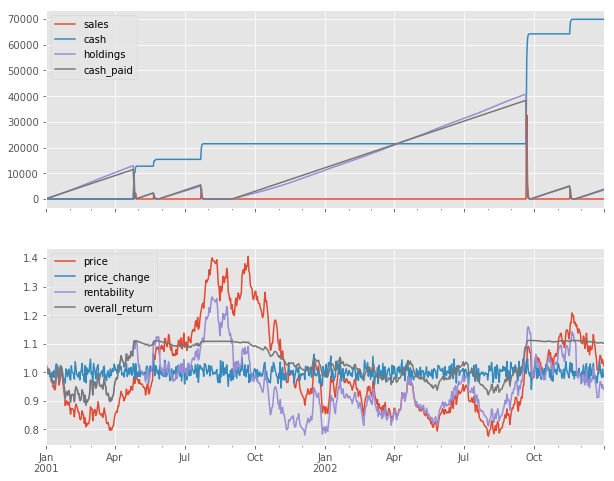

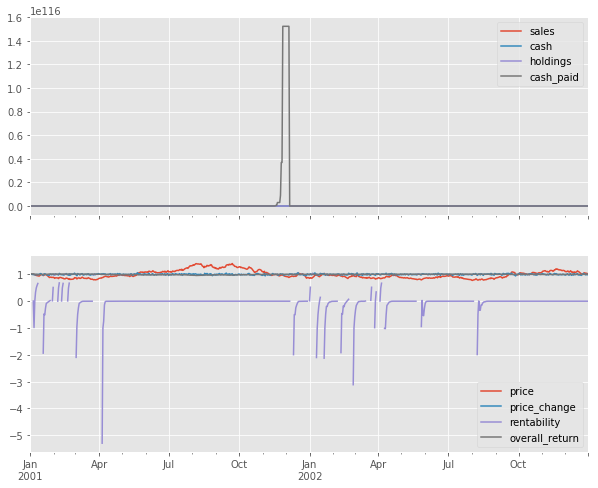

In [17]:
rw = random_walk()
results = strategy_1(rw, threshold=1.1, fraction_to_sell=.8)
dca = dollar_cost_averaging(rw)
plot_random_walk(results)
plot_random_walk(dca)